In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib.transforms as mtransforms
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# Full phase space

In [2]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data


file_name = "pendulum_200_200"
out_name = file_name
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

E = params[:, 0]
data = preprocess(raw_data, MaxAbsScaler)


(-2.240748230859507, 2.240748948228444, -1.872797886449468, 1.8724702710090384)

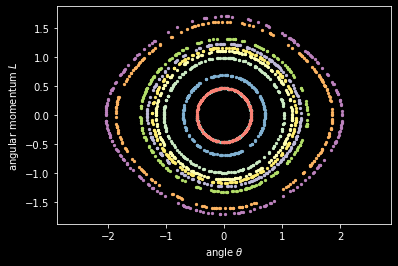

In [3]:
for traj in raw_data[:10]:
    plt.scatter(traj[:, 0], traj[:, 1], s=5.0)
plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular momentum $L$")
plt.axis("equal")


Converged? True
[]


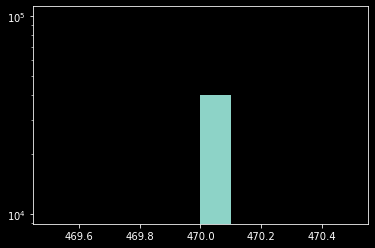

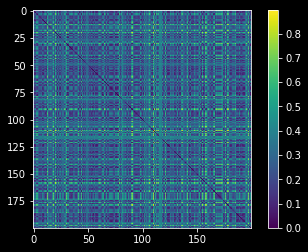

In [4]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4, 2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1 - converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()


In [4]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']


In [7]:
evals, embedding, epsilon = manifold.diffusion_map(
    dist_mat, n_components=20, epsilon="max", n_neighbors=20, alpha=1, robust=True
)


nn_max = 0.47491130232810974
epsilon = 0.4510814901579625
mean_shift = 0.008306567


Text(0, 0.5, 'energy')

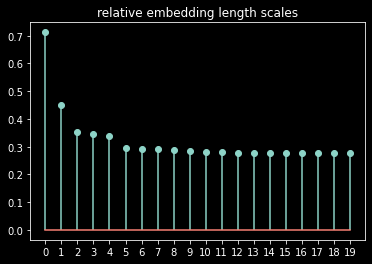

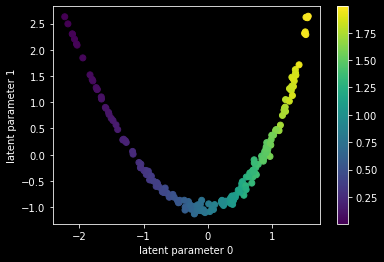

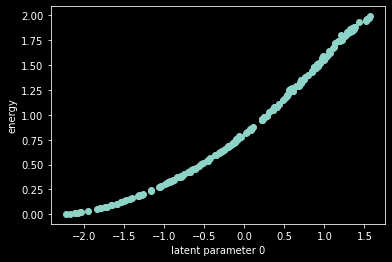

In [8]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon / np.log(1 + evals)), use_line_collection=True)
plt.title("relative embedding length scales")
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=E)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:, 0], E)
plt.xlabel("latent parameter 0")
plt.ylabel("energy")


[0]


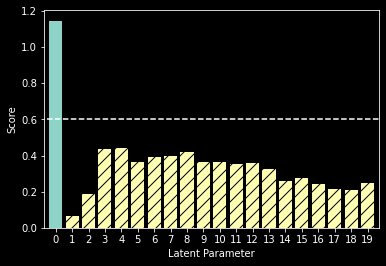

In [9]:
threshold = 0.6
n_components = evals.shape[0]

(embed_list, scores_pass, scores_fail) = manifold.heuristic_importance_score(
    evals, embedding, threshold=threshold, weights="adjusted"
)
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch="//")
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components - 0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, "white", linestyles="dashed")
# plt.savefig("unpredictability_scores.png", dpi=300)


(array([55.,  1.,  5.,  3.,  0.,  0.,  1.,  1.,  1.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

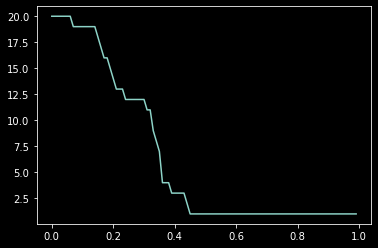

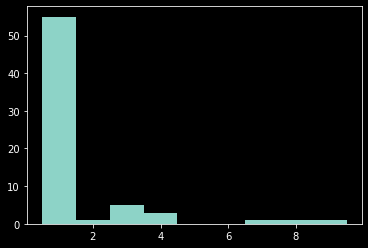

In [10]:
embedding_size_list = []
for thres in np.arange(0.0, 1.0, 0.01):
    embedding_size_list.append(
        len(
            manifold.heuristic_importance_score(
                evals, embedding, threshold=thres, weights="adjusted"
            )[0]
        )
    )

plt.figure()
plt.plot(np.arange(0.0, 1.0, 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10) + 0.5)


R^2 = 0.9618712429855885
Coefficent(s): [0.58291805]
SpearmanrResult(correlation=0.9997374934373362, pvalue=0.0)


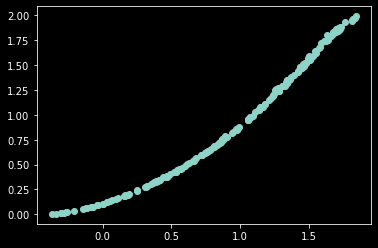

In [11]:
from sklearn.linear_model import LinearRegression

X = embedding[:, embed_list]
y = E
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y)


pendulum_200_200


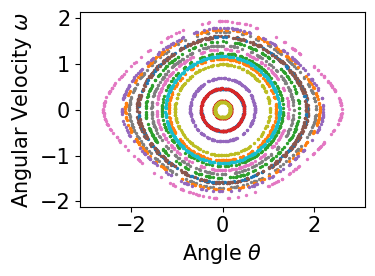

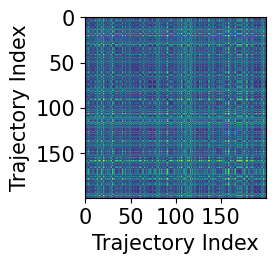

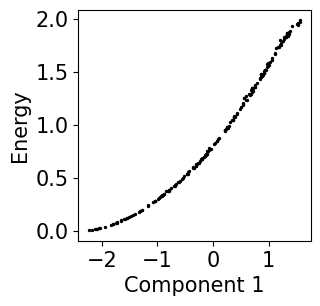

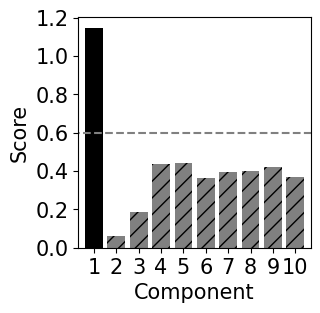

In [50]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(4, 3))
    for traj in raw_data[:20]:
        plt.scatter(traj[:, 0], traj[:, 1], s=2)
    plt.xlabel(r"Angle $\theta$")
    plt.ylabel(r"Angular Velocity $\omega$")
    # plt.axis('off')
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], E, c="k", s=2)
    plt.xlabel("Component 1")
    plt.ylabel("Energy")
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")


## Extra Methods Figures

In [21]:
from ott.core.sinkhorn import sinkhorn
from ott.geometry.epsilon_scheduler import Epsilon
from ott.geometry.pointcloud import PointCloud

x = data[1]
y = data[16]

sol = sinkhorn(
        PointCloud(
            x,
            y,
            cost_fn=None,
            power=2,
            epsilon=Epsilon(
                target=1e-1**2,
                init=10.0**2,
                decay=0.995**2,
            ),
        ),
        threshold=1e-2,
        max_iterations=1000,
    )
print(sol.converged)

True


In [ ]:
from ott.tools import transport, plot

x = data[1]
y = data[16]
ot = transport.solve(x, y, epsilon=1e-1**2)
plot_ot = plot.Plot()
lines = plot_ot._mapping(x, y, ot.matrix);

In [ ]:
filtered_lines = [line for line in lines if line[2] > 0.01]
print(len(filtered_lines))
max_strength = np.max([strength for _,_,strength in filtered_lines])

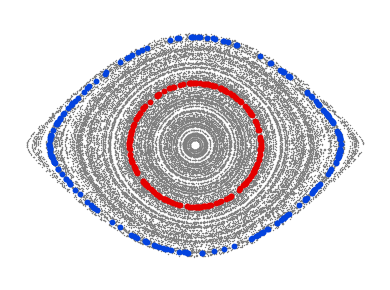

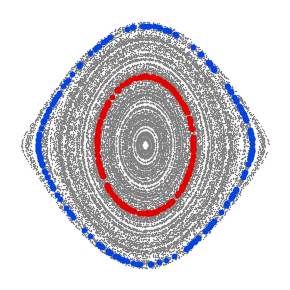

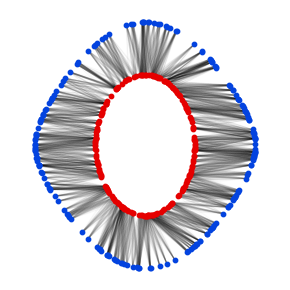

In [143]:
with plt.style.context("default"):
    plt.figure(figsize=(4, 3))
    for traj in raw_data:
        plt.scatter(traj[:, 0], traj[:, 1], s=1, c='gray', linewidth=0)
    plt.scatter(raw_data[1,:,0], raw_data[1,:,1], s=10, c='xkcd:red')
    plt.scatter(raw_data[16,:,0], raw_data[16,:,1], s=10, c='xkcd:blue')
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_raw_data_plain.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    for traj in data:
        plt.scatter(traj[:, 0], traj[:, 1], s=1, c='gray', linewidth=0)
    plt.scatter(x[:,0], x[:,1], s=10, c='xkcd:red')
    plt.scatter(y[:,0], y[:,1], s=10, c='xkcd:blue')
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data_plain.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(x[:,0], x[:,1], s=10, c='xkcd:red')
    plt.scatter(y[:,0], y[:,1], s=10, c='xkcd:blue')
    for start, end, strength in filtered_lines:
        plt.plot(
            start,
            end,
            linewidth=0.5 + 4 * strength,
            color='k',
            zorder=0,
            alpha=float(strength)
        )
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_transport_map.pdf", bbox_inches='tight')

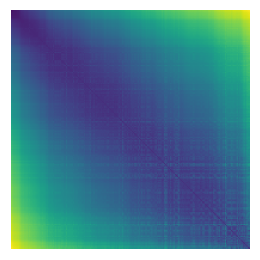

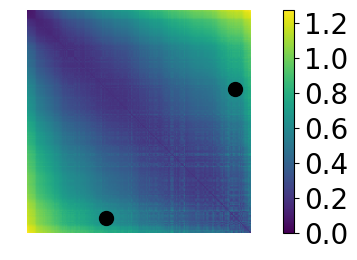

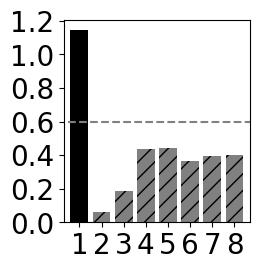

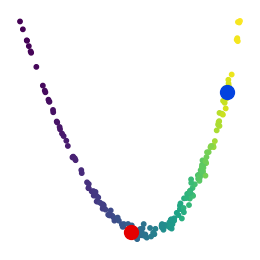

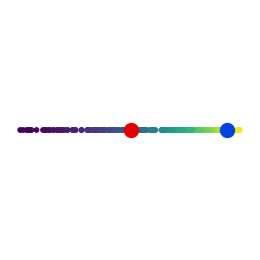

In [26]:
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(3, 3))
    idx = np.argsort(E)
    plt.imshow(dist_mat[idx][:,idx], vmin=0)
    # plt.imshow(dist_mat)
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat_plain.pdf", bbox_inches="tight")

    plt.figure(figsize=(4, 3))
    idx = np.argsort(E)
    plt.imshow(dist_mat[idx][:,idx], vmin=0)
    # plt.imshow(dist_mat)
    plt.colorbar()
    plt.scatter([np.where(idx == 1)[0][0]], [np.where(idx == 16)[0][0]], s=100, c='k')
    plt.scatter([np.where(idx == 16)[0][0]], [np.where(idx == 1)[0][0]], s=100, c='k')
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat_plain_marked.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 8
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    # plt.gca().axis('off')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_score_plain.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=10, c=E)
    plt.scatter(embedding[1,0], embedding[1,1], s=100, c='xkcd:red')
    plt.scatter(embedding[16,0], embedding[16,1], s=100, c='xkcd:blue')
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding2_plain.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], np.zeros_like(embedding[:,0]), s=10, c=E)
    plt.scatter(embedding[1,0], 0, s=100, c='xkcd:red')
    plt.scatter(embedding[16,0], 0, s=100, c='xkcd:blue')
    plt.gca().axis('off')
    plt.gca().axis('equal')
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding_plain.pdf", bbox_inches="tight")

# Position only

In [3]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data[..., [0]]


file_name = "pendulum_200_200"
out_name = file_name + "_pos_only"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

E = params[:, 0]
data = preprocess(raw_data, MaxAbsScaler)


Text(0.5, 0, 'angle $\\theta$')

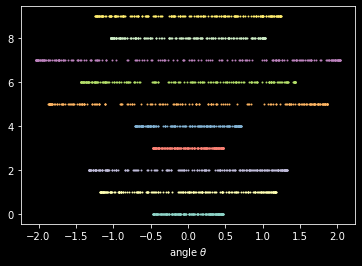

In [4]:
for i, traj in enumerate(raw_data[:10]):
    plt.scatter(traj[:, 0], i * np.ones_like(traj[:, 0]), s=1)
plt.xlabel(r"angle $\theta$")


Converged? True
[]


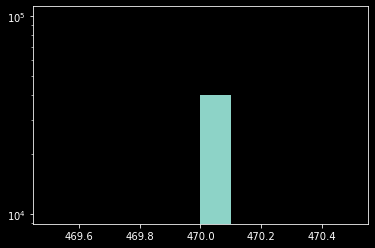

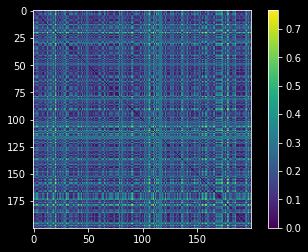

In [48]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4, 2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1 - converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()


In [5]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']


In [6]:
evals, embedding, epsilon = manifold.diffusion_map(
    dist_mat, n_components=20, epsilon="max", n_neighbors=20, alpha=1, robust=True
)


nn_max = 0.2454882562160492
epsilon = 0.12052896787999323
mean_shift = 0.008475777


Text(0, 0.5, 'energy')

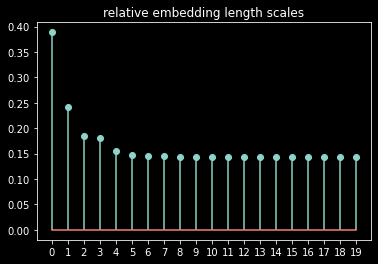

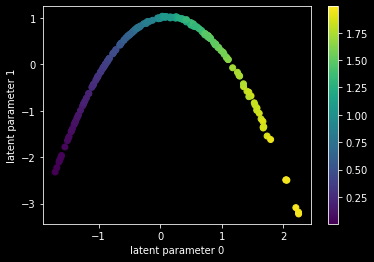

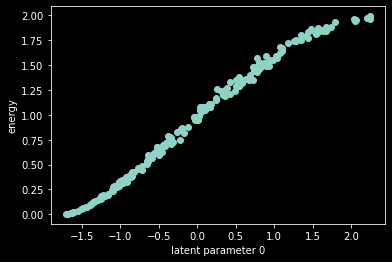

In [7]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon / np.log(1 + evals)), use_line_collection=True)
plt.title("relative embedding length scales")
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=E)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:, 0], E)
plt.xlabel("latent parameter 0")
plt.ylabel("energy")


[0]


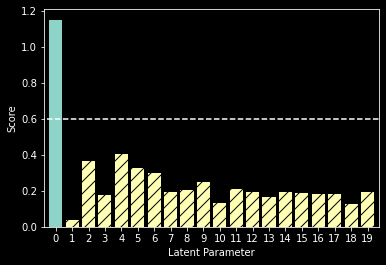

In [8]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(
    evals, embedding, threshold=threshold, weights="adjusted"
)
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch="//")
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components - 0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, "white", linestyles="dashed")


(array([59.,  6.,  2.,  9.,  0.,  2.,  2.,  2.,  1.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

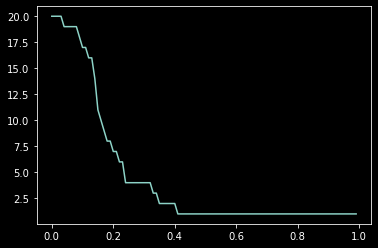

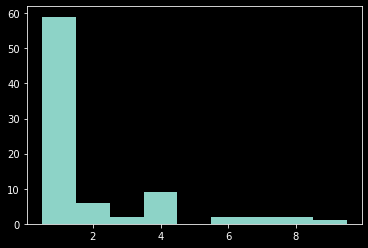

In [9]:
embedding_size_list = []
for thres in np.arange(0.0, 1.0, 0.01):
    embedding_size_list.append(
        len(
            manifold.heuristic_importance_score(
                evals, embedding, threshold=thres, weights="adjusted"
            )[0]
        )
    )

plt.figure()
plt.plot(np.arange(0.0, 1.0, 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10) + 0.5)


R^2 = 0.9870369082795896
Coefficent(s): [0.5906575]
SpearmanrResult(correlation=0.9984009600240008, pvalue=5.051266778258957e-249)


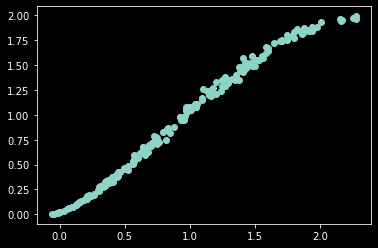

In [11]:
from sklearn.linear_model import LinearRegression

X = embedding[:, embed_list]
y = E
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y)


pendulum_200_200_pos_only


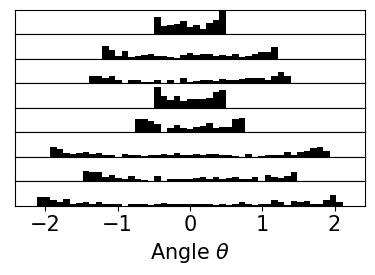

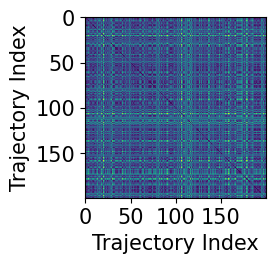

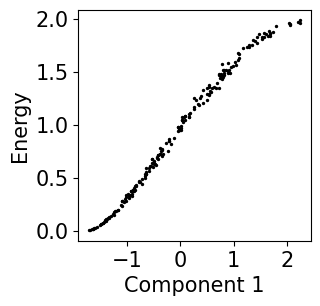

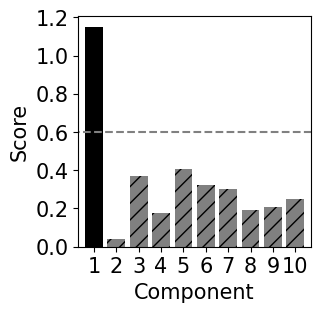

In [12]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(4, 3))
    gs = fig.add_gridspec(8, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)

    for i, traj in enumerate(raw_data[:8, :, 0]):
        axs[i].hist(traj, bins=np.linspace(-2.2, 2.2, 50), color='k')
    plt.xlabel(r"Angle $\theta$")
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], E, c="k", s=2)
    plt.xlabel("Component 1")
    plt.ylabel("Energy")
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")


# Noise

In [13]:
def preprocess(data, scaler, noise=0.0, rng=np.random.default_rng(0)):
    data += rng.normal(scale=noise, size=data.shape)
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data


noise = 0.5
file_name = "pendulum_200_200"
out_name = file_name + f"_noise{noise}"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

E = params[:, 0]
data = preprocess(raw_data, MaxAbsScaler, noise=noise)


(-3.341110722667097,
 3.1698807413410033,
 -3.2715708286057215,
 2.659294650695261)

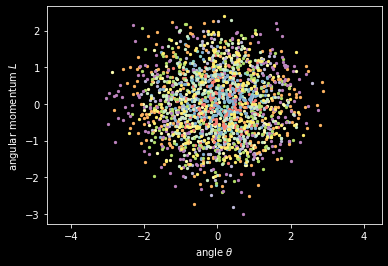

In [14]:
for traj in raw_data[:10]:
    plt.scatter(traj[:, 0], traj[:, 1], s=5.0)
plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular momentum $L$")
plt.axis("equal")


Converged? True
[]


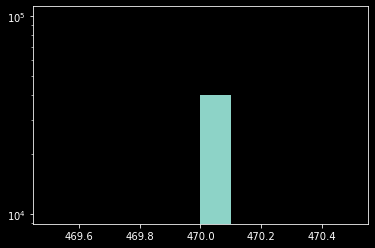

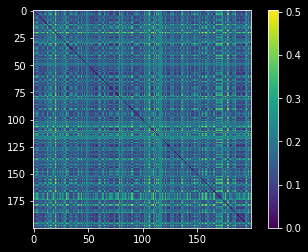

In [80]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4, 2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1 - converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()


In [15]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']


In [16]:
evals, embedding, epsilon = manifold.diffusion_map(
    dist_mat, n_components=20, epsilon="max", n_neighbors=20, alpha=1, robust=True
)


nn_max = 0.20052997767925262
epsilon = 0.08042454389608311
mean_shift = 0.008287853


Text(0, 0.5, 'energy')

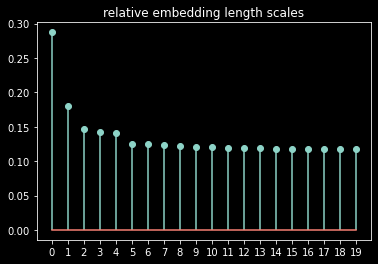

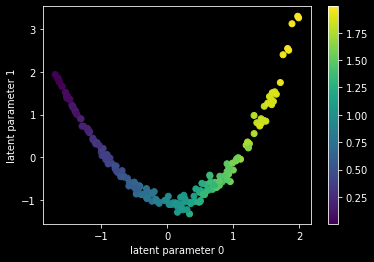

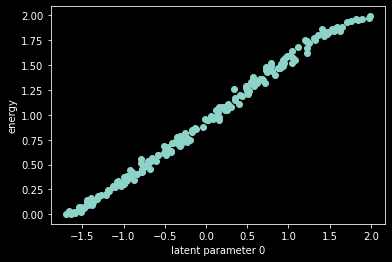

In [17]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon / np.log(1 + evals)), use_line_collection=True)
plt.title("relative embedding length scales")
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=E)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:, 0], E)
plt.xlabel("latent parameter 0")
plt.ylabel("energy")


[0]


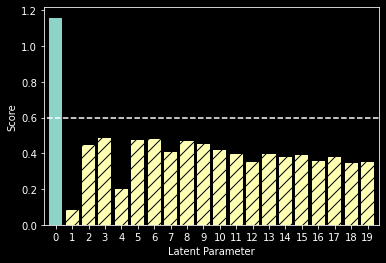

In [18]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(
    evals, embedding, threshold=threshold, weights="adjusted"
)
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch="//")
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components - 0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, "white", linestyles="dashed")
# plt.savefig("unpredictability_scores.png", dpi=300)


(array([51.,  2.,  0.,  2.,  2.,  2.,  2.,  1.,  0.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

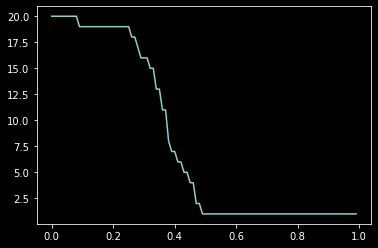

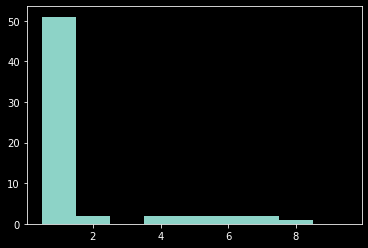

In [19]:
embedding_size_list = []
for thres in np.arange(0.0, 1.0, 0.01):
    embedding_size_list.append(
        len(
            manifold.heuristic_importance_score(
                evals, embedding, threshold=thres, weights="adjusted"
            )[0]
        )
    )

plt.figure()
plt.plot(np.arange(0.0, 1.0, 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10) + 0.5)


R^2 = 0.9943767682298875
Coefficent(s): [0.59277004]
SpearmanrResult(correlation=0.9977634440861023, pvalue=1.3070137557691005e-234)


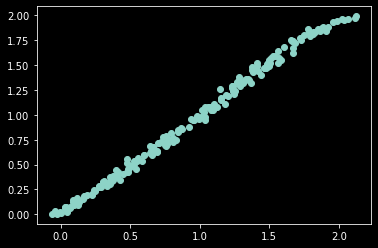

In [20]:
from sklearn.linear_model import LinearRegression

X = embedding[:, embed_list]
y = E
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y)


pendulum_200_200_noise0.5


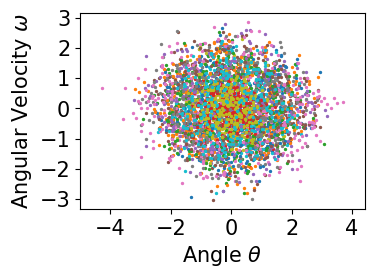

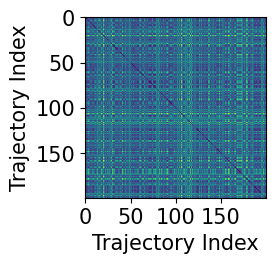

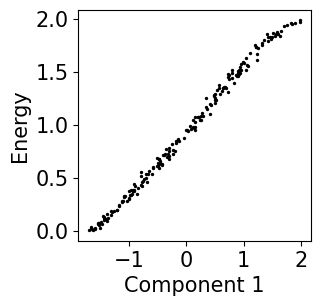

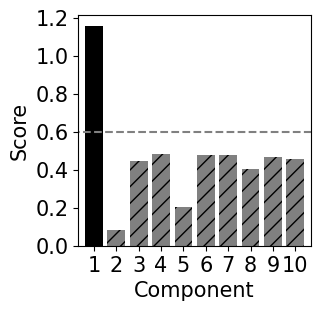

In [38]:
print(out_name)
with plt.style.context("default"):
    plt.figure(figsize=(4, 3))
    plt.rcParams.update({'font.size': 15})
    for traj in raw_data[:20]:
        plt.scatter(traj[:, 0], traj[:, 1], s=2)
    plt.xlabel(r"Angle $\theta$")
    plt.ylabel(r"Angular Velocity $\omega$")
    # plt.axis('off')
    plt.axis("equal")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], E, c="k", s=2)
    plt.xlabel("Component 1")
    plt.ylabel("Energy")
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")


# Position only + noise

In [2]:
def preprocess(data, scaler, noise=0.0, rng=np.random.default_rng(0)):
    data += rng.normal(scale=noise, size=data.shape)
    scaled_data = scaler().fit_transform(data.reshape(-1, 2)).reshape(data.shape)
    return scaled_data[..., [0]]


noise = 0.5
file_name = "pendulum_200_200"
out_name = file_name + f"_pos_only_noise{noise}"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

E = params[:, 0]
data = preprocess(raw_data, MaxAbsScaler, noise=noise)

Converged? True
[]


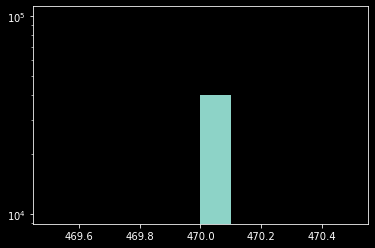

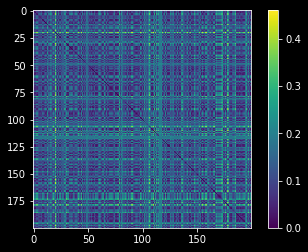

In [3]:
dist_mat, converged, steps = metrics.distance_matrix(data, mesh_shape=(4, 2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1 - converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar()

In [4]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']


In [7]:
evals, embedding, epsilon = manifold.diffusion_map(
    dist_mat, n_components=20, epsilon="max", n_neighbors=20, alpha=1, robust=True
)


nn_max = 0.1648188680410385
epsilon = 0.05433051852465853
mean_shift = 0.008072528


Text(0, 0.5, 'energy')

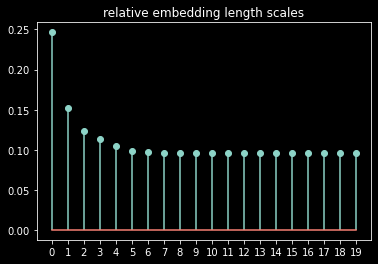

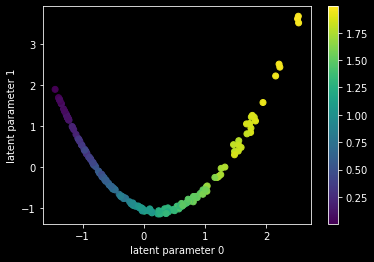

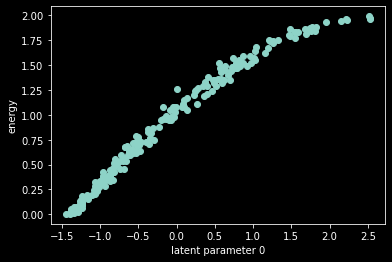

In [8]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon / np.log(1 + evals)), use_line_collection=True)
plt.title("relative embedding length scales")
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=E)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 1")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:, 0], E)
plt.xlabel("latent parameter 0")
plt.ylabel("energy")


[0]


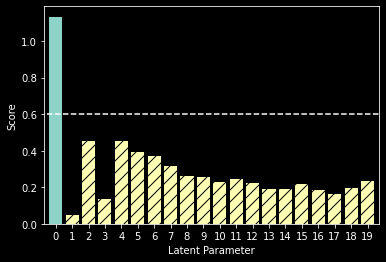

In [9]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(
    evals, embedding, threshold=threshold, weights="adjusted"
)
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch="//")
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components - 0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, "white", linestyles="dashed")
# plt.savefig("unpredictability_scores.png", dpi=300)


R^2 = 0.9619886917179323
Coefficent(s): [0.5833126]
SpearmanrResult(correlation=0.995633390834771, pvalue=6.874227239716838e-206)


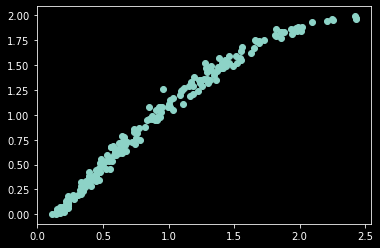

In [10]:
from sklearn.linear_model import LinearRegression

X = embedding[:, embed_list]
y = E
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)

from scipy.stats import spearmanr
print(spearmanr(reg.predict(X), y))

plt.figure()
plt.scatter(reg.predict(X), y)


pendulum_200_200_pos_only_noise0.5


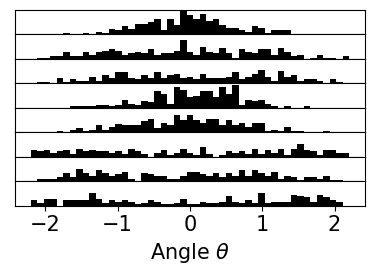

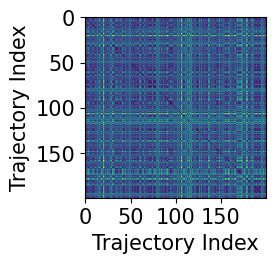

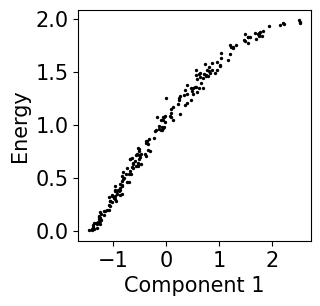

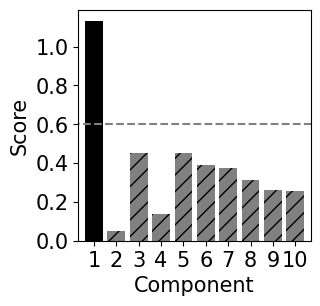

In [11]:
print(out_name)
with plt.style.context("default"):
    plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(4, 3))
    gs = fig.add_gridspec(8, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)

    for i, traj in enumerate(raw_data[:8, :, 0]):
        axs[i].hist(traj, bins=np.linspace(-2.2, 2.2, 50), color='k')
    plt.xlabel(r"Angle $\theta$")
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.scatter(embedding[:, 0], E, c="k", s=2)
    plt.xlabel("Component 1")
    plt.ylabel("Energy")
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 10
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(1, n_components+1)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(1, n_components+1)[:n_show_components])
    plt.xlim(0.3, n_show_components + 0.7)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Component")
    plt.hlines(threshold, 0, n_show_components+1, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")
